In [1]:
%pip install astropy astroquery numpy scipy matplotlib



Note: you may need to restart the kernel to use updated packages.


In [2]:
from astropy.io import fits
from astropy.table import Table

# 1. Load the FITS image
hdu = fits.open('M31_R_29092016.fits')[0]
image_data = hdu.data
wcs_header = hdu.header  # holds the raw WCS keywords, if any

# 2. Load your astrometric‐standards file
#    It’s a whitespace‐delimited ASCII table, so:
stds = Table.read(
    '50_astrometric_standards_M31N_2016-8e_vicinity.dat',
    format='ascii'
)

# 3. Inspect the columns and first few rows to confirm it loaded correctly
print(stds.colnames)
print(stds[:])


['_RAJ2000', '_DEJ2000', 'Vmag', 'B-V', 'V-R']
 _RAJ2000   _DEJ2000   Vmag   B-V    V-R 
---------- ---------- ------ ------ -----
10.9726667 41.5383056 15.033  0.563 0.327
   10.8335 41.6003333 15.042  0.809  0.42
11.0408333 41.4708333 15.119  0.729 0.382
 11.134625 41.5834722 15.184  0.821 0.428
10.9400417 41.5034444 15.219  0.848 0.445
    10.845 41.4446111 15.287  0.623 0.336
11.0027917 41.3536667 15.309  0.929 0.497
10.8832917 41.5621667 15.374  0.689 0.369
11.0070833 41.3254444 15.374  0.692 0.409
11.0139583   41.37825 15.399  0.728 0.408
       ...        ...    ...    ...   ...
  10.98475 41.4570556 16.493  0.593 0.366
10.7519583 41.4725833 16.497  0.901 0.478
11.0336667 41.3468611 16.497 -0.004 0.051
  10.75325 41.2962222  16.51  0.671 0.381
  11.06825 41.3507778 16.519  0.323 0.229
    11.128 41.4259722 16.528    0.7 0.431
11.0797917 41.4283611 16.536  0.885 0.505
10.8719167 41.4865556 16.543  1.264 0.753
10.8718333 41.4466944 16.558  0.751 0.426
11.0374167    41.4345 16.567 

In [3]:
%pip install --user photutils

Note: you may need to restart the kernel to use updated packages.


Detected 2789 stars


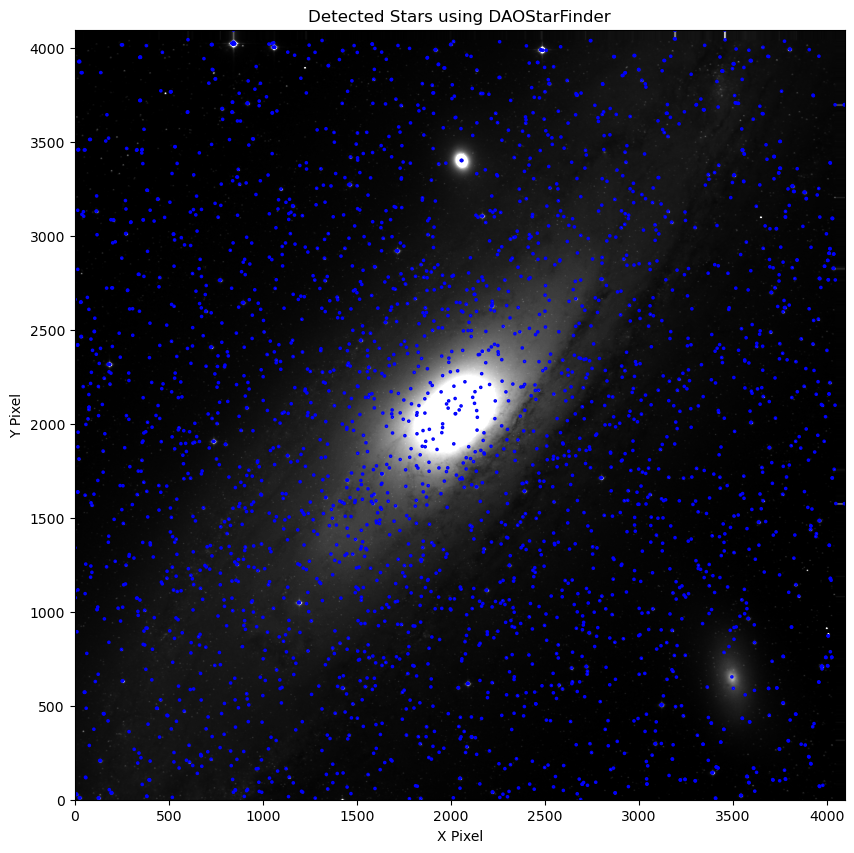

In [4]:
from astropy.io import fits
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
import matplotlib.pyplot as plt
import numpy as np

# Load the FITS image
fits_path = 'M31_R_29092016.fits'
data = fits.getdata(fits_path)

# Estimate background noise using MAD
bkg_sigma = mad_std(data)

# Initialize DAOStarFinder
# fwhm is estimated (e.g. 3), and threshold is ~5*sigma above background
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*bkg_sigma)

# Detect sources
sources = daofind(data)

# Show number of detections
print(f"Detected {len(sources)} stars")

# Plot the image and overlay the detected stars
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)

plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
apertures.plot(color='blue', lw=1.5)
plt.title('Detected Stars using DAOStarFinder')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.grid(False)
plt.show()

# Optionally, save coordinates to CSV
sources.write('detected_sources.csv', format='csv', overwrite=True)



In [5]:
from astropy.table import Table
stds = Table.read('50_astrometric_standards_M31N_2016-8e_vicinity.dat', format='ascii')
stds.pprint(max_lines=-1)  # View all entries


 _RAJ2000   _DEJ2000   Vmag   B-V    V-R 
---------- ---------- ------ ------ -----
10.9726667 41.5383056 15.033  0.563 0.327
   10.8335 41.6003333 15.042  0.809  0.42
11.0408333 41.4708333 15.119  0.729 0.382
 11.134625 41.5834722 15.184  0.821 0.428
10.9400417 41.5034444 15.219  0.848 0.445
    10.845 41.4446111 15.287  0.623 0.336
11.0027917 41.3536667 15.309  0.929 0.497
10.8832917 41.5621667 15.374  0.689 0.369
11.0070833 41.3254444 15.374  0.692 0.409
11.0139583   41.37825 15.399  0.728 0.408
 10.778625 41.4957778 15.435  1.421 0.694
10.8414167 41.3821111 15.556  0.895 0.484
 10.814125 41.4408889 15.563  0.893 0.472
 11.115625 41.5681944 15.594  0.672 0.379
10.9549167 41.3692778 15.614  0.728 0.416
  10.80625 41.5684167 15.695  0.763 0.427
10.9879583 41.2758889 15.744  0.731 0.417
10.7522917 41.3938611 15.796  0.521 0.327
10.7557083    41.5305 15.848  0.899 0.483
 10.881625 41.4060278  15.85  0.709 0.413
 10.851375 41.4435833 15.889  0.699  0.39
 11.116375   41.42525 15.946  0.68

In [6]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

# Load .dat file
stds = Table.read('50_astrometric_standards_M31N_2016-8e_vicinity.dat', format='ascii')

# Convert to SkyCoord
coords = SkyCoord(ra=stds['_RAJ2000'], dec=stds['_DEJ2000'], unit=(u.hourangle, u.deg))

# Filter: Keep only finite, valid coordinates
valid = coords.ra.deg > 0  # crude but works; can also do ~coords.ra.is_nan() if needed

# Create DS9 region file
with open('astrometric_standards.reg', 'w') as f:
    f.write("# Region file format: DS9 version 4.1\n")
    f.write("global color=cyan font=\"helvetica 10\" select=1 edit=1 move=1 delete=1 include=1 fixed=0\n")
    f.write("fk5\n")

    for i, (ra, dec) in enumerate(zip(coords.ra.deg, coords.dec.deg)):
        if np.isfinite(ra) and np.isfinite(dec):
            f.write(f"point({ra:.6f},{dec:.6f}) # point=circle text={{{i+1}}}\n")



In [7]:
from astropy.table import Table

# Load star catalog
stds = Table.read('50_astrometric_standards_M31N_2016-8e_vicinity.dat', format='ascii')

# Define image RA/Dec bounds
ra_center = 10.6752
dec_center = 41.2708
half_size = 0.615

ra_min = ra_center - half_size
ra_max = ra_center + half_size
dec_min = dec_center - half_size
dec_max = dec_center + half_size

# Filter stars inside field
in_field = stds[(stds['_RAJ2000'] > ra_min) & (stds['_RAJ2000'] < ra_max) &
                (stds['_DEJ2000'] > dec_min) & (stds['_DEJ2000'] < dec_max)]

# Sort by distance from center (optional)
from astropy.coordinates import SkyCoord
import astropy.units as u

center = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg)
coords = SkyCoord(ra=in_field['_RAJ2000']*u.deg, dec=in_field['_DEJ2000']*u.deg)
separations = center.separation(coords)

in_field['sep_arcmin'] = separations.arcminute
in_field.sort('sep_arcmin')


In [8]:
for i, row in enumerate(in_field):
    print(f"{i+1:2d}. RA: {row['_RAJ2000']:.6f}, Dec: {row['_DEJ2000']:.6f}, Vmag: {row['Vmag']:.3f}, sep: {row['sep_arcmin']:.2f}′")


 1. RA: 10.753250, Dec: 41.296222, Vmag: 16.510, sep: 3.84′
 2. RA: 10.817917, Dec: 41.300250, Vmag: 16.434, sep: 6.67′
 3. RA: 10.753708, Dec: 41.381333, Vmag: 16.256, sep: 7.52′
 4. RA: 10.752292, Dec: 41.393861, Vmag: 15.796, sep: 8.16′
 5. RA: 10.841417, Dec: 41.382111, Vmag: 15.556, sep: 10.03′
 6. RA: 10.869750, Dec: 41.389333, Vmag: 16.396, sep: 11.29′
 7. RA: 10.884958, Dec: 41.376111, Vmag: 16.471, sep: 11.37′
 8. RA: 10.814125, Dec: 41.440889, Vmag: 15.563, sep: 11.97′
 9. RA: 10.849292, Dec: 41.427556, Vmag: 16.384, sep: 12.25′
10. RA: 10.881625, Dec: 41.406028, Vmag: 15.850, sep: 12.34′
11. RA: 10.751958, Dec: 41.472583, Vmag: 16.497, sep: 12.59′
12. RA: 10.845000, Dec: 41.444611, Vmag: 15.287, sep: 12.93′
13. RA: 10.851375, Dec: 41.443583, Vmag: 15.889, sep: 13.05′
14. RA: 10.897667, Dec: 41.411139, Vmag: 16.388, sep: 13.09′
15. RA: 10.871833, Dec: 41.446694, Vmag: 16.558, sep: 13.78′
16. RA: 10.954917, Dec: 41.369278, Vmag: 15.614, sep: 13.92′
17. RA: 10.920500, Dec: 41.4

In [11]:
from astropy.io import fits
from astropy.table import Table
from astropy.stats import mad_std
from astropy.modeling import models, fitting

# photutils import compatibility
try:
    # older photutils (<1.0)
    from photutils import DAOStarFinder
except ImportError:
    # newer photutils (>=1.0)
    from photutils.detection import DAOStarFinder


# 1) Load image
hdul = fits.open('M31_R_29092016.fits')
img = hdul[0].data
hdul.close()

# 2) Detect stars
bkg_sigma = mad_std(img)
daofind  = DAOStarFinder(fwhm=3.0, threshold=5.*bkg_sigma)
sources  = daofind(img - img.mean())
stars    = sources[sources['sharpness'] > 0.2]  # optional clean-up

# 3) Load catalog of standards
catalog = Table.read('50_astrometric_standards_M31N_2016-8e_vicinity.dat',
                     format='ascii.commented_header')
# assume columns: 'x_pix','y_pix','RA_deg','DEC_deg'
x_std, y_std = catalog['x_pix'], catalog['y_pix']
ra_std, dec_std = catalog['RA_deg'], catalog['DEC_deg']

# 4) Fit a 2D affine transform
affine_init = models.AffineTransformation2D()
fitter = fitting.LinearLSQFitter()
fitted = fitter(affine_init, x_std, y_std, np.vstack([ra_std, dec_std]).T)

# 5) Compute nova coords
nova_x, nova_y = 1303.499, 1488.394
nova_ra, nova_dec = fitted(nova_x, nova_y)
print(f"Nova M31 2016-08e → RA = {nova_ra:.6f}°, Dec = {nova_dec:.6f}°")


KeyError: 'x_pix'